In [2]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT','raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var


# full_adata recluster to show MEL vs KRT

In [5]:
%%capture

full_adata = process_adata(raw_adata)
pca_adata(full_adata, num_pcs=30)
umap_adata(full_adata, res=0.05)

... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical


# module scoring

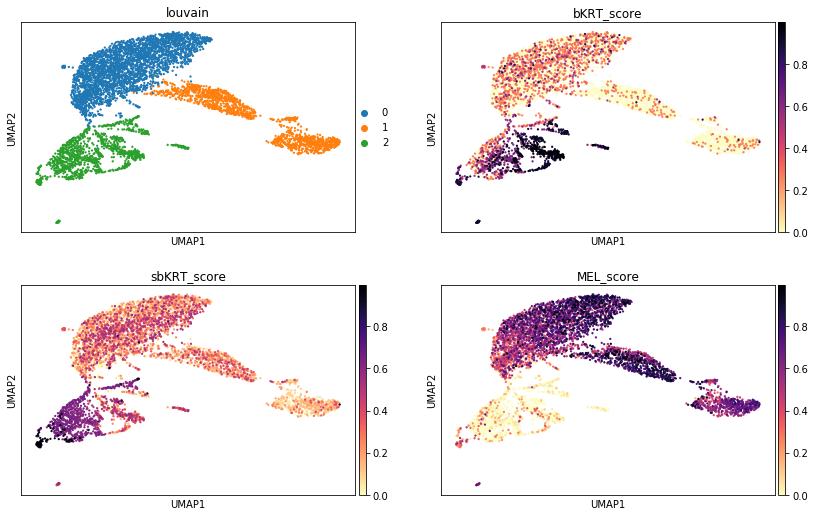

In [22]:
def greater_than (exp_vec):
    return list(map(lambda x: stats.percentileofscore(exp_vec, x, kind='strict')/100, exp_vec))

#SORT_module = ['ITGA6','KIT','ITGAX']
MEL_module = ['PMEL','TYR','DCT','MITF','TYRP1','SOX10']
bKRT_module = ['ITGB4','KRT14','KRT5']
sbKRT_module = ['KRT1','KRT10','IVL']


test_adata = full_adata
test_adata.obs['cell'] = test_adata.obs.index.tolist()
test_adata.obs['cell'] = (test_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(test_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(test_adata,
                 var_names = MEL_module+bKRT_module+sbKRT_module,
                 groupby = 'cell')
exp_df = exp_df.apply(greater_than, axis=0)
test_adata.obs['MEL_score'] = exp_df.loc[:,MEL_module].mean(axis=1)
test_adata.obs['bKRT_score'] = exp_df.loc[:,bKRT_module].mean(axis=1)
test_adata.obs['sbKRT_score'] = exp_df.loc[:,sbKRT_module].mean(axis=1)

sc.pl.umap(test_adata, color=['louvain','bKRT_score','sbKRT_score','MEL_score'], ncols = 2, cmap = 'magma_r')
# sc.pl.umap(full_adata, color=MEL_module)
# sc.pl.umap(full_adata, color=KRT_module)



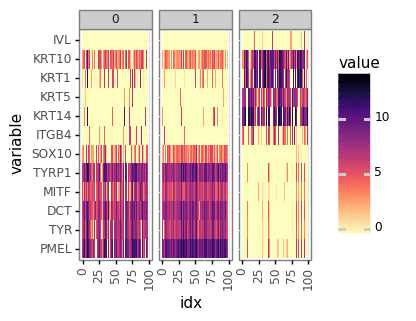

<ggplot: (-9223363303562498044)>


In [11]:
cat, exp_df = prepare_dataframe(test_adata,
                 var_names = MEL_module+bKRT_module+sbKRT_module,
                 groupby = 'cell')

exp_df['louvain'] = test_adata.obs.louvain.tolist()
# sample 100 cells from each louvain cluster
exp_df_melt = pd.melt((exp_df
                       .groupby('louvain')
                       .apply(lambda x: (x.sample(100)
                                         .assign(idx = lambda x: [i for i in range(len(x))])
                                        )
                             )
                      ), id_vars=['louvain','idx']
                     )
exp_df_melt['module'] = ['MEL' if x in MEL_module else 'KRT' for x in exp_df_melt.variable]
exp_df_melt['variable'] = (exp_df_melt['variable']
                           .astype(str)
                           .astype(CategoricalDtype(MEL_module+bKRT_module+sbKRT_module, ordered=True))
                          )

print(ggplot(exp_df_melt)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid('~louvain')
      + scale_fill_cmap('magma_r')
     )


... storing 'dev_stage' as categorical
... storing 'subtypes' as categorical


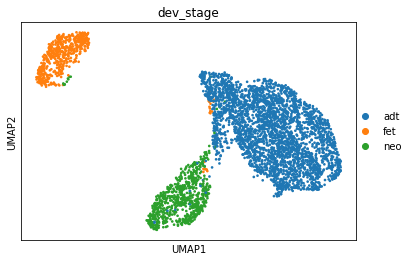

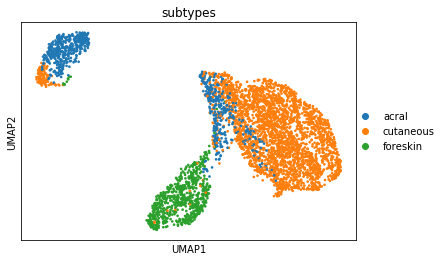

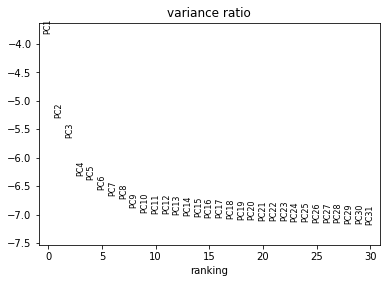

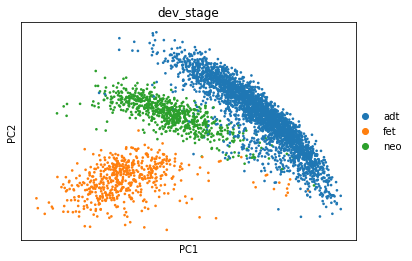

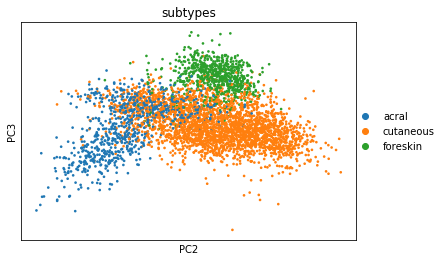

In [35]:
adata_subset2.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in adata_subset2.obs.age]
adata_subset2.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in adata_subset2.obs.general_location]

sc.pl.umap(adata_subset2, color = ['dev_stage'])
sc.pl.umap(adata_subset2, color = ['subtypes'])
sc.pl.pca_variance_ratio(adata_subset2, log=True)
sc.pl.pca(adata_subset2, components=['1,2'], color=['dev_stage'])
sc.pl.pca(adata_subset2, components=['2,3'], color=['subtypes'])


... storing 'subtypes' as categorical


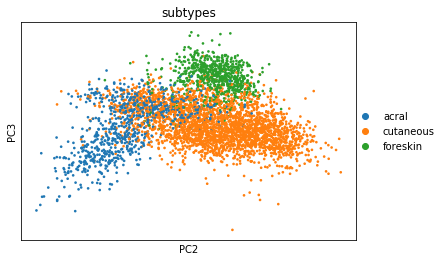

In [ ]:
# project KRT subtype scores on cluster 2

... storing 'noise_group' as categorical


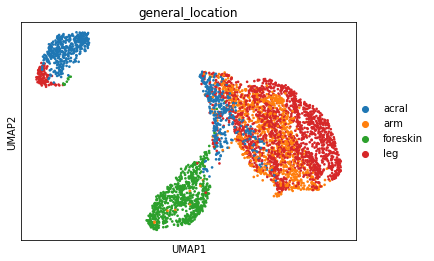

In [116]:
# location matched adt vs fet
sc.pl.umap(adata_subset2, color = 'general_location')

In [ ]:
# compare cut fet vs cut adult

## PCA to show 
## IF
## heatmap of DE genes
## Gene ontology of fet expression
## GSEA melanoma oncogene overlap? # see manuscript channel

In [ ]:
# spearman correlation for cancer cell line vs fet/adt/acr/cut

In [ ]:
# age-correlation on proportion of cells expressing
# maybe GSEA on age-dependent expresssion + %cells expressing

# DEV

## outlier detection on KRT subset

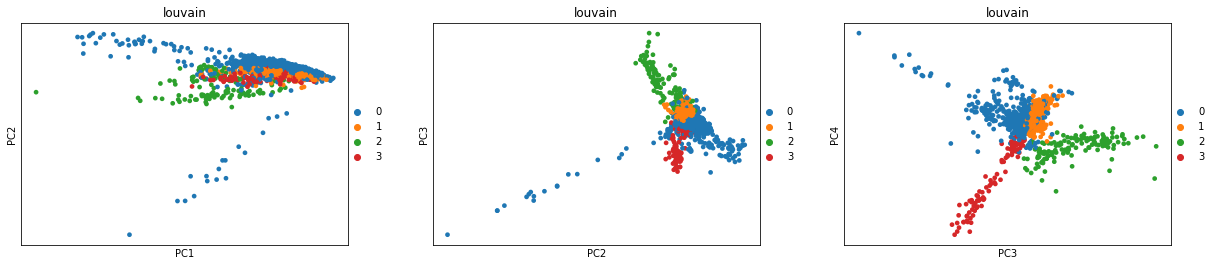

Filtered cells:  201


... storing 'outliers' as categorical


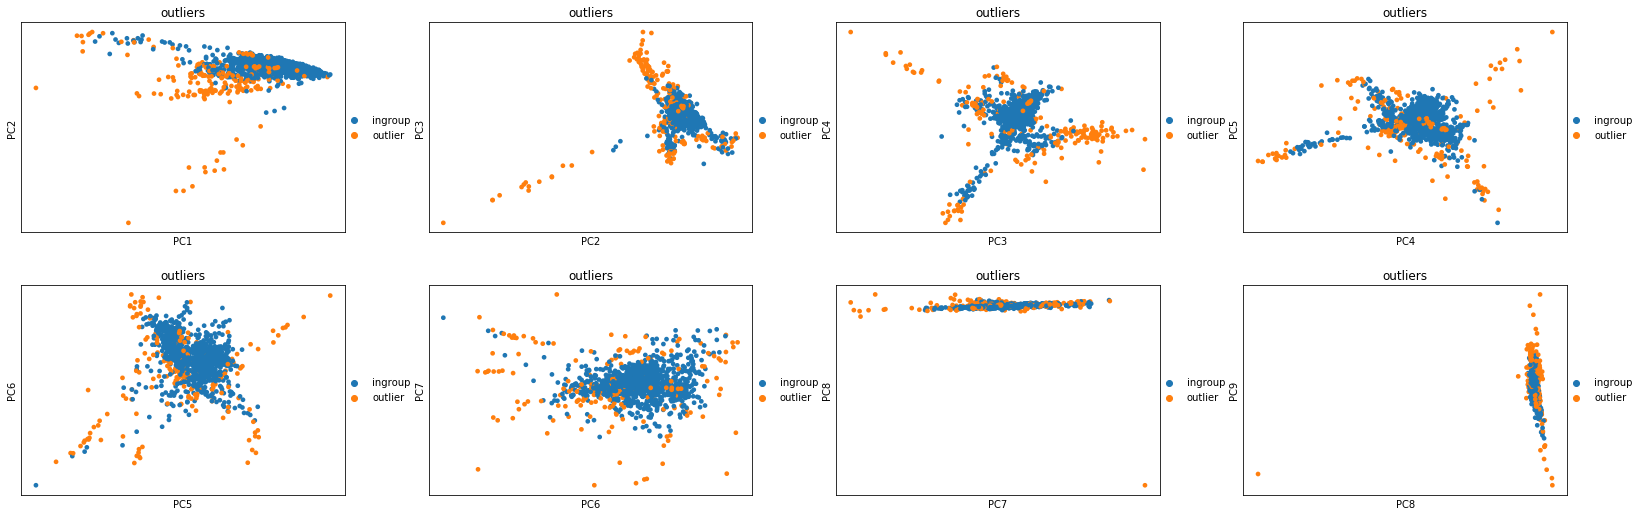

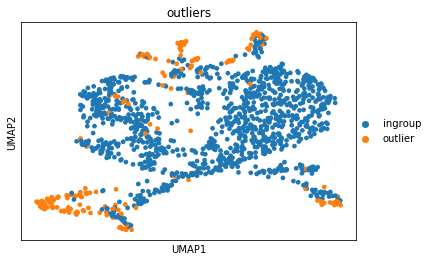

In [70]:
# classify in raw adata


# PCA outlier detection
# initial PC coordinates
input_adata = adata_subset1_KRT
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(input_adata.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=5

    bool_idx = [((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) for x in df[pc]]
    filtered = df[bool_idx]
    
    omit_names = omit_names + input_adata.obs[[x == False for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))

# check where the outliers lie in original projection
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4','4,5',
                                   '5,6','6,7','7,8','8,9'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')



In [71]:
# update with krt outliers
full_adata.obs.outliers = ['outlier' if x in omit_names else y for x,y in zip(full_adata.obs.index, full_adata.obs.outliers)]

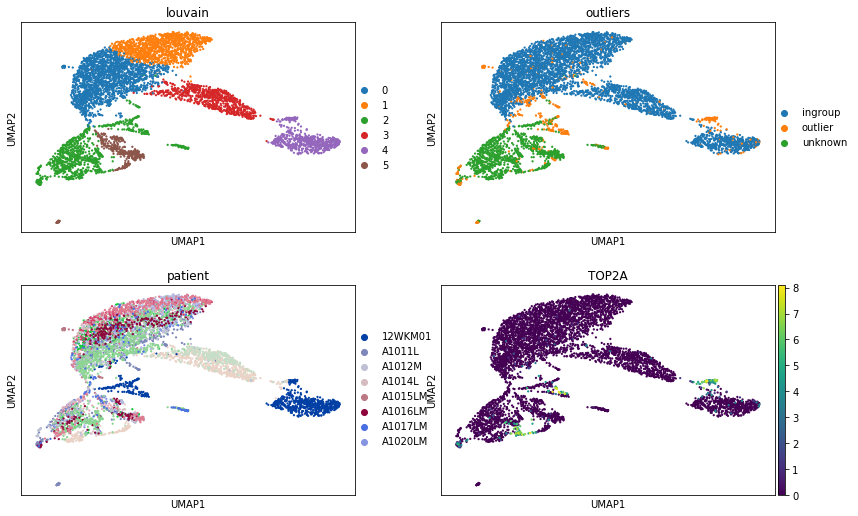

In [74]:
sc.pl.umap(full_adata, color=['louvain','outliers','patient','TOP2A'], ncols = 2)


## Recluster all cells sans fsk

Process expression data...
	Initial:
	Cells: 5002, Genes: 23783
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13341
	Result:
	Cells: 5002, Genes: 10442
Principle component analysis...


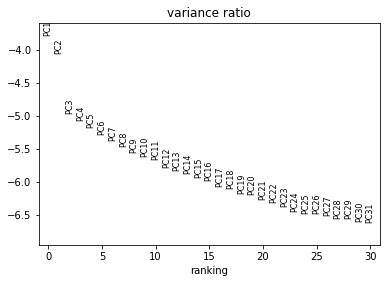

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


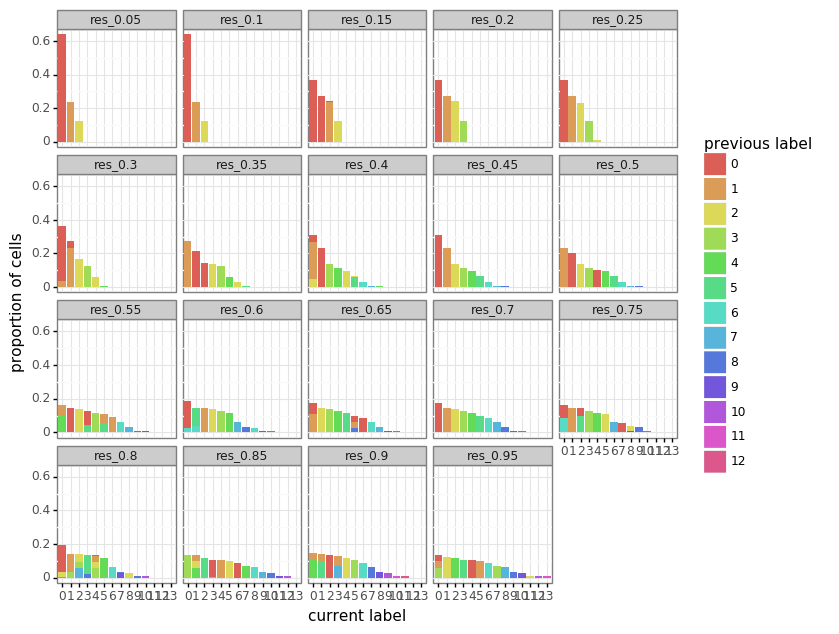

<ggplot: (8748117693560)>


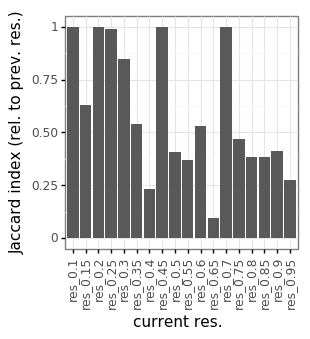

<ggplot: (8748134113123)>
resolution(res): 0.1


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical


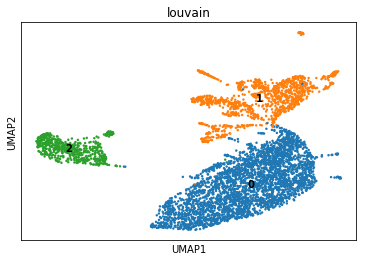

In [23]:
# omit fsk
raw_adata = raw_adata[[x not in ['foreskin'] for x in raw_adata.obs.general_location]]

# recluster on raw
full_adata_nofsk = process_adata(raw_adata)
pca_adata(full_adata_nofsk, num_pcs=30)
umap_adata(full_adata_nofsk, res=0.1)


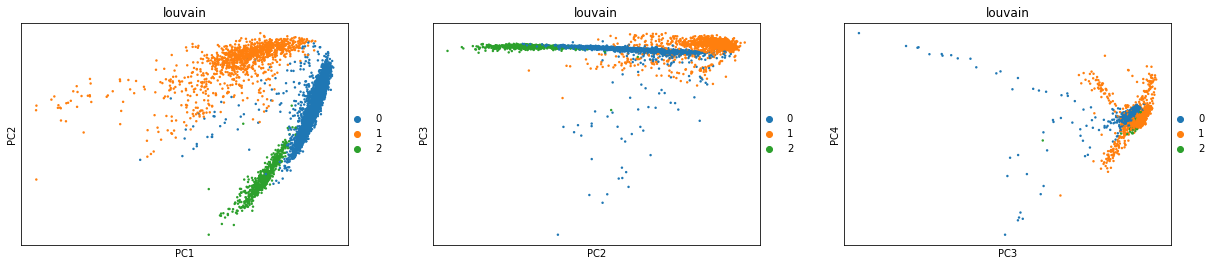

Filtered cells:  416


... storing 'outliers' as categorical


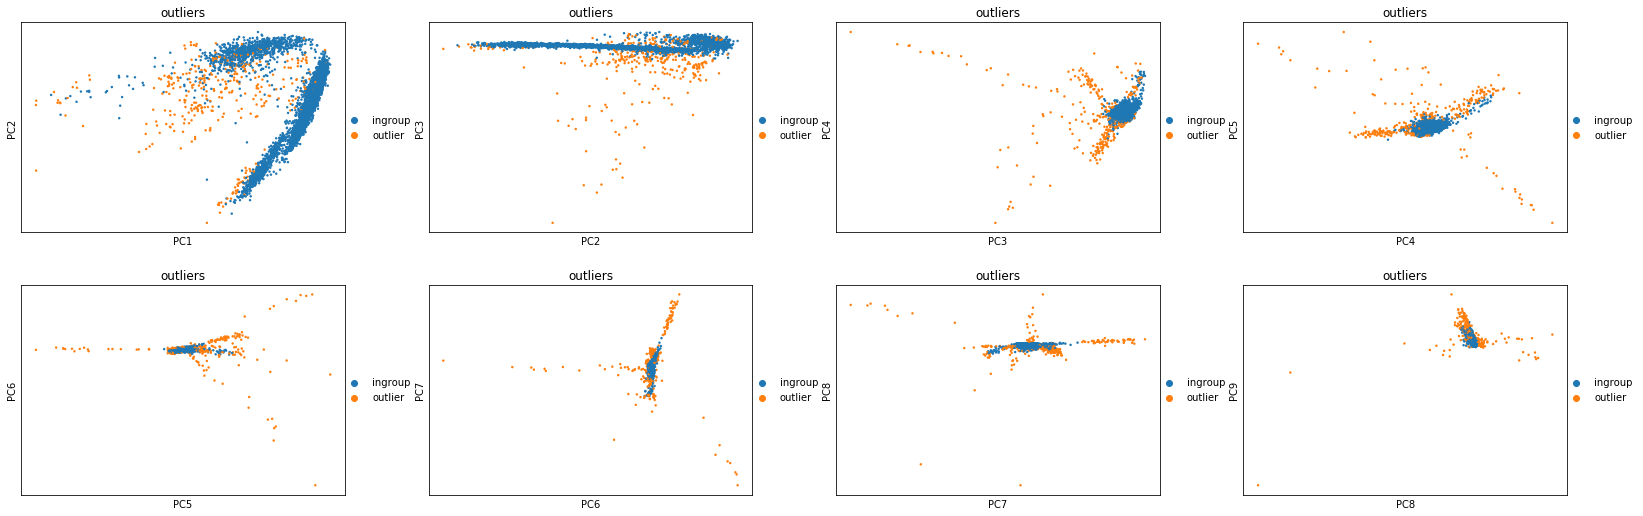

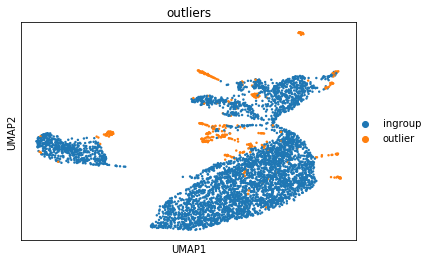

In [57]:
# PCA outlier detection
# initial PC coordinates
input_adata = full_adata_nofsk
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(input_adata.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=7

    bool_idx = [True if ((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) else False for x in df[pc]]    
    omit_names = omit_names + input_adata.obs[[x == False for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))

# check where the outliers lie in original projection
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4','4,5',
                                   '5,6','6,7','7,8','8,9'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')


key = class_2, value = in, matched = 4586
	Cells: 4586, Genes: 23783
Process expression data...
	Initial:
	Cells: 4586, Genes: 23783
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13137
	Result:
	Cells: 4586, Genes: 10646
Principle component analysis...


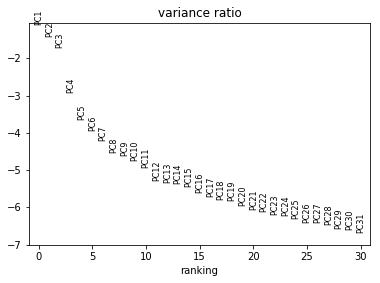

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


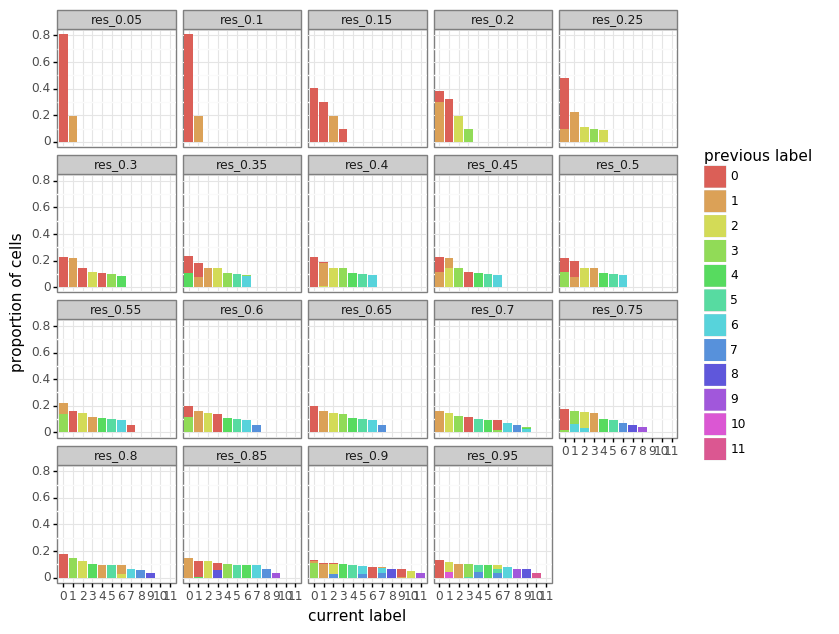

<ggplot: (-9223363288735067353)>


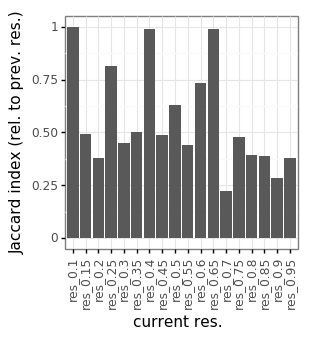

<ggplot: (-9223363288736541422)>
resolution(res): 0.1


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_2' as categorical


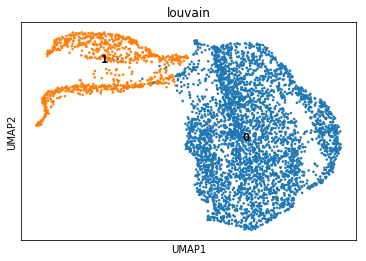

In [33]:
# classify in raw adata
input_adata = full_adata_nofsk

type_dict = {'in':['ingroup'],
             'out':['outlier']}
    
classify_type(raw_adata, input_adata, 'outliers', type_dict, 'class_2')

feature_dict = {'class_2':['in']}
full_adata_nofsk_trimmed = subset_adata_v3(raw_adata,feature_dict)
adata_subset2 = process_adata(full_adata_nofsk_trimmed)
pca_adata(full_adata_nofsk_trimmed, num_pcs=30)
umap_adata(full_adata_nofsk_trimmed, res=0.1)


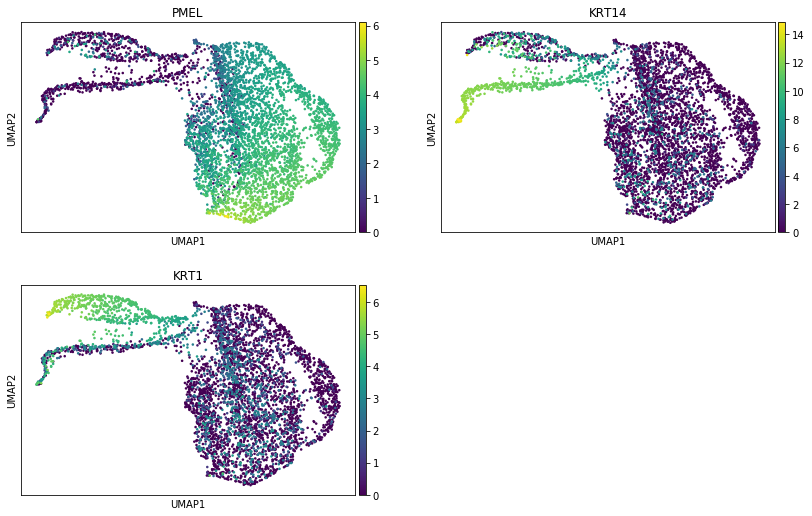

In [39]:
sc.pl.umap(full_adata_nofsk_trimmed, color = ['PMEL',
                                              'KRT14',
                                              'KRT1'],ncols=2)

# Only adt and fet MEL recluster

Process expression data...
	Initial:
	Cells: 3551, Genes: 23783
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13374
	Result:
	Cells: 3551, Genes: 10409
Principle component analysis...


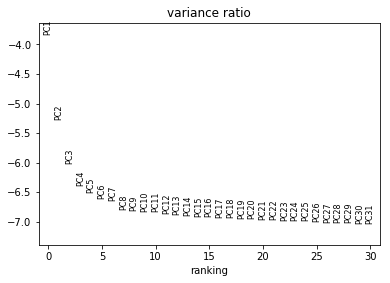

principle_components(num_pcs): 10
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


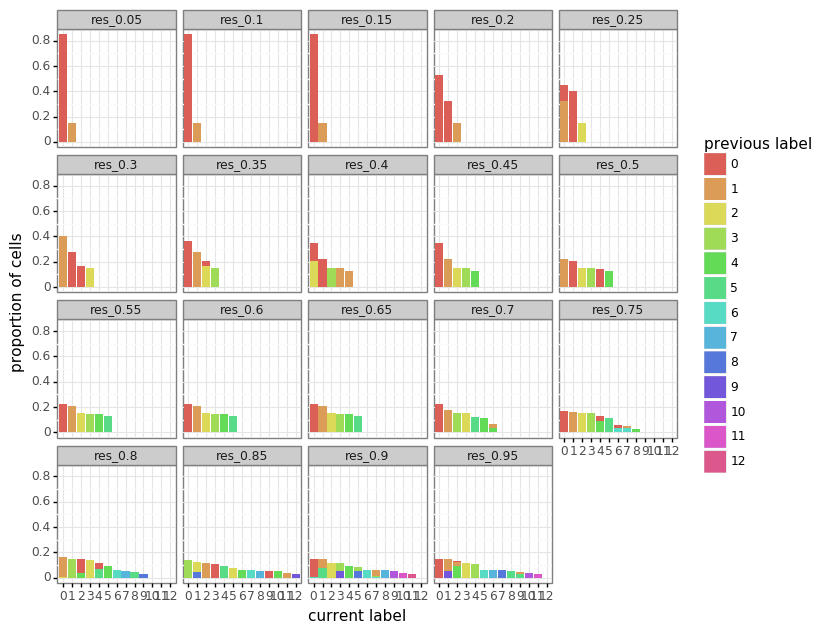

<ggplot: (8753265223628)>


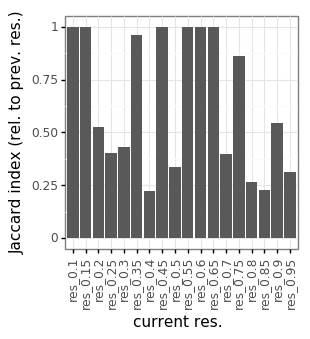

<ggplot: (8753264184114)>
resolution(res): 0.1


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical


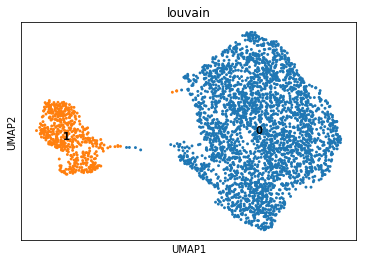

In [134]:
# omit fsk and krt
raw_adata_filtered = raw_adata[[x not in ['foreskin'] and y in adata_subset2.obs.index.tolist() for x,y in zip(raw_adata.obs.general_location, 
                                                                                                         raw_adata.obs.index)]]

# recluster on raw
full_adata_nofsk_krt = process_adata(raw_adata_filtered)
pca_adata(full_adata_nofsk_krt, num_pcs=10)
umap_adata(full_adata_nofsk_krt, res=0.1)
